# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Загрузка используемых в проекте библиотек

In [1]:
# Необходимый набор библиотек
!pip install matplotlib==3.7.3 numpy==1.22 seaborn==0.11.1 -q
!pip install --upgrade scikit-learn -q
!pip install shap -q
!pip install phik -q
!pip install python-levenshtein -q

# Работа с данными
import pandas as pd
import numpy as np

# Визуализация, построение графиков
from matplotlib import pyplot as plt
import seaborn as sns

# Применение регулярных выражений
import re

# Вывод корреляционной матрицы
import phik

# Тест Шапиро-Уилка
from scipy.stats import shapiro

# Разбиение данных на тренировочную выборку и тестовую
from sklearn.model_selection import train_test_split

# Создание pipeline
from sklearn.pipeline import Pipeline

# Классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# Класс для работы с пропусками
from sklearn.impute import SimpleImputer

# Функция для работы с метриками
from sklearn.metrics import roc_auc_score, make_scorer, root_mean_squared_error

# RandomizedSearchCV - библиотека, которая используется для рандомизированного поиска гиперпараметров в машинном обучении
# GridSearchCV - библиотека, которая помогает автоматизировать настройку гиперпараметров в машинном обучении
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Модели машинного обучения
# Логистическая регрессия
from sklearn.linear_model import LogisticRegression
# Линейная регрессия
from sklearn.linear_model import LinearRegression
# k-ближайших соседей
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# Дерево решений
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
# Метод опорных векторов
from sklearn.svm import SVC, SVR

# Кодировка целевого признака
from sklearn.preprocessing import LabelEncoder
import shap

# Проверка уникальности значений в object
from fuzzywuzzy import fuzz

# Настройка вывода всех столбцов для метода display
pd.set_option('display.max_columns', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Загрузка данных

Загрузим данные предоставленные заказчиком и отобразим первичную информацию по каждому датасету

In [2]:
# Тренировочная выборка
geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
# Входные признаки тестовой выборки
geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
# Целевой признак тестовой выборки
geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
# Создадим функцию отоброжения первичной информации о датасете (выборке)
def data_head_desc_info(data):
    try:
        # сразу преобразуем наименование столбцов в нижний регистр и стиль snake_case
        data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).replace(' ', '_').lower() for i in data.columns]
        print('---------------------------------------------------------------------------------------------------------------')
        print('Первые 3 строки:')
        print('---------------------------------------------------------------------------------------------------------------')
        display(data.head(3))
        print('---------------------------------------------------------------------------------------------------------------')
        print('Описание данных:')
        print('---------------------------------------------------------------------------------------------------------------')
        display(data.describe(include = "all"))
        print('---------------------------------------------------------------------------------------------------------------')
        print('Общая информация о датафрейме')
        print('---------------------------------------------------------------------------------------------------------------')
        display(data.info())
        print('---------------------------------------------------------------------------------------------------------------')
        print('Исследование пропусков')
        print('---------------------------------------------------------------------------------------------------------------')
        frame = {
                'nan_кол-во': data.isna().sum().sort_values(ascending=False),
                'nan_%': round((data.isna().mean() * 100), 1).sort_values(ascending=False),
            }
        nan_data = pd.DataFrame(frame)
        nan_data = nan_data.style.format({'nan_%': '{:.1f}%'})
        nan_data = nan_data.background_gradient(axis=0, cmap='YlOrRd')
        display(nan_data)
        print('---------------------------------------------------------------------------------------------------------------')
        print('Доля явных дубликатов')
        print('---------------------------------------------------------------------------------------------------------------')
        print(f"{data.duplicated().sum() / data.shape[0] * 100:.2f}%")
    except:
        return 'Проверьте параметры'

### Обзор данных

#### geo_data_0

In [4]:
data_head_desc_info(geo_data_0)

---------------------------------------------------------------------------------------------------------------
Первые 3 строки:
---------------------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


---------------------------------------------------------------------------------------------------------------
Описание данных:
---------------------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99990,NaN,NaN,NaN,NaN
top,TtcGQ,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.500419,0.250143,2.502647,92.500000
std,NaN,0.871832,0.504433,3.248248,44.288691
min,NaN,-1.408605,-0.848218,-12.088328,0.000000
25%,NaN,-0.072580,-0.200881,0.287748,56.497507
50%,NaN,0.502360,0.250252,2.515969,91.849972
75%,NaN,1.073581,0.700646,4.715088,128.564089


---------------------------------------------------------------------------------------------------------------
Общая информация о датафрейме
---------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

---------------------------------------------------------------------------------------------------------------
Исследование пропусков
---------------------------------------------------------------------------------------------------------------


,nan_кол-во,nan_%
id,0,0.0%
f0,0,0.0%
f1,0,0.0%
f2,0,0.0%
product,0,0.0%


---------------------------------------------------------------------------------------------------------------
Доля явных дубликатов
---------------------------------------------------------------------------------------------------------------
0.00%


In [5]:
geo_data_0['id'].duplicated().sum()

10

In [6]:
duplicates = geo_data_0[geo_data_0['id'].duplicated(keep=False)]

for id in duplicates['id'].unique():
    print(f"id: {id}")
    print("Оригинал/Дубликат:")
    display(duplicates[duplicates['id'] == id])
    print("---------------------")

id: HZww2
Оригинал/Дубликат:


,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


---------------------
id: bxg6G
Оригинал/Дубликат:


,id,f0,f1,f2,product
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798


---------------------
id: QcMuo
Оригинал/Дубликат:


,id,f0,f1,f2,product
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675


---------------------
id: A5aEY
Оригинал/Дубликат:


,id,f0,f1,f2,product
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


---------------------
id: fiKDv
Оригинал/Дубликат:


,id,f0,f1,f2,product
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
90815,fiKDv,0.049883,0.841313,6.394613,137.346586


---------------------
id: Tdehs
Оригинал/Дубликат:


,id,f0,f1,f2,product
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
75715,Tdehs,0.112079,0.430296,3.218993,60.964018


---------------------
id: AGS9W
Оригинал/Дубликат:


,id,f0,f1,f2,product
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453


---------------------
id: TtcGQ
Оригинал/Дубликат:


,id,f0,f1,f2,product
60140,TtcGQ,0.569276,-0.104876,6.440215,85.350186
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008


---------------------
id: 74z30
Оригинал/Дубликат:


,id,f0,f1,f2,product
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327


---------------------
id: bsk9y
Оригинал/Дубликат:


,id,f0,f1,f2,product
89582,bsk9y,0.398908,-0.400253,10.122376,163.433078
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


---------------------


In [7]:
geo_data_0 = geo_data_0.sort_values(by='product', ascending = False)
geo_data_0 = geo_data_0.drop_duplicates(subset='id', keep='last')
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 8826 to 57263
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [8]:
# Проверка правильно ли удалили дубликаты, значение product должно быть 30.68
display(geo_data_0[geo_data_0['id'] == 'HZww2'])

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774


#### geo_data_1

In [9]:
data_head_desc_info(geo_data_1)

---------------------------------------------------------------------------------------------------------------
Первые 3 строки:
---------------------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


---------------------------------------------------------------------------------------------------------------
Описание данных:
---------------------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,5ltQ6,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,1.141296,-4.796579,2.494541,68.825000
std,NaN,8.965932,5.119872,1.703572,45.944423
min,NaN,-31.609576,-26.358598,-0.018144,0.000000
25%,NaN,-6.298551,-8.267985,1.000021,26.953261
50%,NaN,1.153055,-4.813172,2.011479,57.085625
75%,NaN,8.621015,-1.332816,3.999904,107.813044


---------------------------------------------------------------------------------------------------------------
Общая информация о датафрейме
---------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

---------------------------------------------------------------------------------------------------------------
Исследование пропусков
---------------------------------------------------------------------------------------------------------------


,nan_кол-во,nan_%
id,0,0.0%
f0,0,0.0%
f1,0,0.0%
f2,0,0.0%
product,0,0.0%


---------------------------------------------------------------------------------------------------------------
Доля явных дубликатов
---------------------------------------------------------------------------------------------------------------
0.00%


In [10]:
# Количество дубликатов в id
geo_data_1['id'].duplicated().sum()

4

In [11]:
# Выводим дубликаты в id
duplicates = geo_data_1[geo_data_1['id'].duplicated(keep=False)]

for id in duplicates['id'].unique():
    print(f"id: {id}")
    print("Оригинал/Дубликат:")
    display(duplicates[duplicates['id'] == id])
    print("---------------------")

id: LHZR0
Оригинал/Дубликат:


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


---------------------
id: bfPNe
Оригинал/Дубликат:


,id,f0,f1,f2,product
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886


---------------------
id: 5ltQ6
Оригинал/Дубликат:


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


---------------------
id: wt4Uk
Оригинал/Дубликат:


,id,f0,f1,f2,product
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


---------------------


In [12]:
# Удаляем дубликаты
geo_data_1 = geo_data_1.sort_values(by='product', ascending = False)
geo_data_1 = geo_data_1.drop_duplicates(subset='id', keep='last')
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 53864 to 42537
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [13]:
# Проверка
display(geo_data_1[geo_data_1['id'] == 'wt4Uk'])

,id,f0,f1,f2,product
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103


#### geo_data_2

In [14]:
data_head_desc_info(geo_data_2)

---------------------------------------------------------------------------------------------------------------
Первые 3 строки:
---------------------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


---------------------------------------------------------------------------------------------------------------
Описание данных:
---------------------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,VF7Jo,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.002023,-0.002081,2.495128,95.000000
std,NaN,1.732045,1.730417,3.473445,44.749921
min,NaN,-8.760004,-7.084020,-11.970335,0.000000
25%,NaN,-1.162288,-1.174820,0.130359,59.450441
50%,NaN,0.009424,-0.009482,2.484236,94.925613
75%,NaN,1.158535,1.163678,4.858794,130.595027


---------------------------------------------------------------------------------------------------------------
Общая информация о датафрейме
---------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

---------------------------------------------------------------------------------------------------------------
Исследование пропусков
---------------------------------------------------------------------------------------------------------------


,nan_кол-во,nan_%
id,0,0.0%
f0,0,0.0%
f1,0,0.0%
f2,0,0.0%
product,0,0.0%


---------------------------------------------------------------------------------------------------------------
Доля явных дубликатов
---------------------------------------------------------------------------------------------------------------
0.00%


In [15]:
# Количество дубликатов в id
geo_data_2['id'].duplicated().sum()

4

In [16]:
# Выводим дубликаты в id
duplicates = geo_data_2[geo_data_2['id'].duplicated(keep=False)]

for id in duplicates['id'].unique():
    print(f"id: {id}")
    print("Оригинал/Дубликат:")
    display(duplicates[duplicates['id'] == id])
    print("---------------------")

id: VF7Jo
Оригинал/Дубликат:


,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420


---------------------
id: xCHr8
Оригинал/Дубликат:


,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


---------------------
id: Vcm5J
Оригинал/Дубликат:


,id,f0,f1,f2,product
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


---------------------
id: KUPhW
Оригинал/Дубликат:


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802


---------------------


In [17]:
# Удаляем дубликаты
geo_data_2 = geo_data_2.sort_values(by='product', ascending = False)
geo_data_2 = geo_data_2.drop_duplicates(subset='id', keep='last')
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 79705 to 68149
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [18]:
# Проверка
display(geo_data_2.query('id == "KUPhW"'))

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299


id имеет смысл сделать индексом, чтобы данные id не участвовали в обучении модели. Другая предобработка данных не требуется. 

In [19]:
geo_data_0 = geo_data_0.set_index('id')
geo_data_1 = geo_data_1.set_index('id')
geo_data_2 = geo_data_2.set_index('id')

In [20]:
# Проверим, что id стал индексом
print(geo_data_0.index)
print(geo_data_1.index)
print(geo_data_2.index)

Index(['rjMou', '7cHIv', 'uCDzR', 'IfqrC', '5FEPb', 'bII2i', '8nZzW', 'jMdal',
       'AXcMW', 'TBC3a',
       ...
       'WIzvk', 'NDc1S', '8mAMo', 'dBUmk', 'RvDlF', 'EeI1x', 'kmJjD', 'YcHB5',
       'oZ3UJ', 'zCM5W'],
      dtype='object', name='id', length=99990)
Index(['MzRzn', 'nW6eC', 'xwJzQ', 'Xd8DC', 'Stdrb', 'ImlRy', 'WzBhx', 'qqyeH',
       'c0mBf', 'tlA9U',
       ...
       '8Ug4I', 'PLbAQ', 'vxoKl', '1UqZf', 'oPbFc', 'ZO5rv', 'dg885', '1rxbb',
       'qtGm8', 'cR1Ll'],
      dtype='object', name='id', length=99996)
Index(['UAhji', 'IB0JE', '2HeCn', 'dldNH', 'CpuBi', 'OCUyV', 'JcCZ7', 'ZDbiY',
       'mSZSb', 'CmOXJ',
       ...
       'c7hiP', 'qDnLB', 'NmSOh', 'uXoIE', 'wS7Q1', 'Qi2Do', 'ABIo5', 'TNDTo',
       'xMjFy', 'qeefd'],
      dtype='object', name='id', length=99996)


### Распределение данных

Обучение моедли будет происходить на алгоритме линейной регрессии, который очень чувствителен к распределению данных. Лучше всего алгоритм работает на данных с распределением близким к нормальному. Поэтому взглянем как распределяются данные в нащих выборках.

*Нормальное расспределение - это особый тип распределения, при котором большинство значений сосредоточено около среднего. Его также называют гауссовым распределением, законом Гаусса или колоколообразным распределением, а его график — кривой Гаусса, или гауссианой. В нормальном распределении большинство значений находятся в пределах одного среднеквадратического отклонения от среднего (68,2%), двух среднеквадратических отклонений (95,4%)*

<Figure size 1440x720 with 0 Axes>

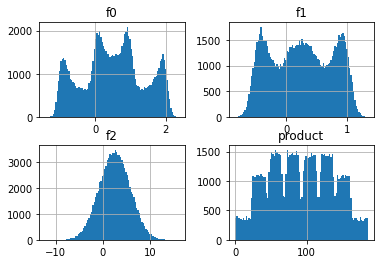

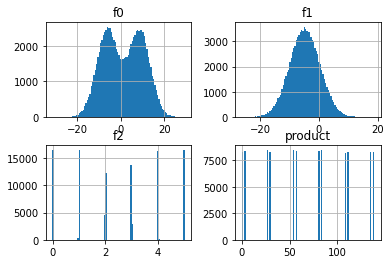

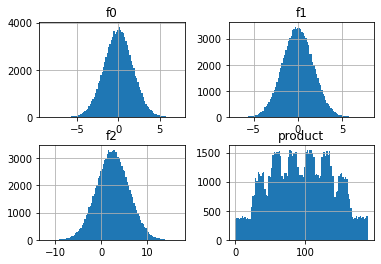

In [21]:
plt.figure(figsize=(20, 10))

dfs = [geo_data_0, geo_data_1, geo_data_2]

for df in dfs:
    df.hist(bins = 100)

In [ ]:
import plotly.express as px

dfs = [geo_data_0, geo_data_1, geo_data_2]
names = ['geo_data_0', 'geo_data_1', 'geo_data_2']

for i, df in enumerate(dfs):
    for column in df.columns: 
        fig = px.histogram(
            df,
            x=column,
            marginal='box',
            opacity=0.5,
            barmode='group',
            title=f'Распределение значений столбца {column} для {names[i]}'
        )
        fig.update_layout(
            width=450,  
            height=300,  
        )
        fig.show()

In [ ]:
for i, df in enumerate(dfs):
    # Вычисляем статистические показатели
    mean = df.mean()
    std = df.std()
    
    # Вычисляем количество значений в пределах одного и двух стандартных отклонений
    within_one_std = ((df - mean).abs() <= std).sum()
    within_two_std = ((df - mean).abs() <= 2 * std).sum()
    
    # Вычисляем проценты
    percent_one_std = within_one_std / len(df) * 100
    percent_two_std = within_two_std / len(df) * 100

    # Выводим информацию
    print(f"--- DataFrame {i + 1} ---")
    for col in df.columns:
        print(f"Значений в пределах одного стандартного отклонения для столбца {col}: {percent_one_std[col]:.2f}%")
        print(f"Значений в пределах двух стандартных отклонений для столбца {col}: {percent_two_std[col]:.2f}%")
        print("-----")
    print("---------------------")

Распределение данных в пределах 1 - 2 стандартных отклонений близко к нормальному распределению. Также распределение имеет симетрию, что положительно влияет на обучение моделей, но при этом видим, что многие гистограммы имеют не колокообразную форму, что может исказить результаты обучения моделей.

## Обучение и проверка модели

In [ ]:
print(geo_data_0.info())
print(geo_data_1.info())
print(geo_data_2.info())

### Корреляционный анализ

In [ ]:
# Список количественных столбцов
interval_cols = ['f0', 'f1', 'f2']

dfs = [geo_data_0, geo_data_1, geo_data_2]
names = ['geo_data_0', 'geo_data_1', 'geo_data_2']

# Вычисляем матрицы корреляции. Передаем только список с количественными признаками. 
# Дальше phik определит остальные признаки как категориальные
for df, name in zip(dfs, names):
    corr_matrix = df.phik_matrix(interval_cols=interval_cols)

    # Визуализация матрицы корреляции
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Phi_K Correlation Matrix for {name}') 
    plt.show()
    print(corr_matrix['product'].sort_values(ascending=False))

### Создание пайплайна

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

def train_and_evaluate(data, region_name):
    # Разделяем данные на обучающую и валидационную выборки
    features = data.drop('product', axis=1)
    target = data['product']
    X_train, X_valid, y_train, y_valid = train_test_split(
        features, target, test_size=0.25, random_state=42
    )

    # Создаем пайплайн
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge())
    ])

    # Задаем диапазон значений для гиперпараметра alpha
    param_grid = {
        # Гиперпараметр alpha упарвляет силой регуляризации в Ridge(L2-регуляризация) и Lasso(L1-регуляризация)
        'regressor__alpha': [0.1, 1.0, 10.0],
        # Список моделей регуляризации
        'regressor': [Ridge(), Lasso()] # Список моделей регуляризации
    }

    # Создаем GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=10,
        scoring='neg_root_mean_squared_error'
    )

    # Обучаем GridSearchCV
    grid_search.fit(X_train, y_train)

    # Получаем наилучшую модель
    best_model = grid_search.best_estimator_
    print(f'Лучшая модель для {region_name} и её параметры:\n\n', grid_search.best_estimator_)
    print ('Метрика RMSE лучшей модели на тренировочной выборке:', grid_search.best_score_)

    # Делаем предсказания
    y_pred = best_model.predict(X_valid)

    # Сохраняем предсказания и правильные ответы
    predictions = pd.DataFrame({'true': y_valid, 'predicted': y_pred})
    predictions.to_csv(f'predictions_{region_name}.csv', index=False)

    # Вычисляем средний запас предсказанного сырья и RMSE
    mean_predicted_reserves = y_pred.mean()
    rmse = root_mean_squared_error(y_valid, y_pred)

    print(f'Регион: {region_name}')
    print(f'Средний запас предсказанного сырья: {mean_predicted_reserves:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print('------------------------------------------')
    
    return best_model

# Обучаем и оцениваем модель для каждого региона
best_model_geo_data_0 = train_and_evaluate(geo_data_0, 'geo_data_0')
best_model_geo_data_1 = train_and_evaluate(geo_data_1, 'geo_data_1')
best_model_geo_data_2 = train_and_evaluate(geo_data_2, 'geo_data_2')

### Вывод

Видим, что средний запас предсказанного сырья во втром регионе в полтора раа меньше чем в остальных двух. Но и модель для второго региона работает намного лучше. Ошибка модели для второго региона меньше единицы, что позволяет делать рассчеты и выводы на основе этой модели надежными. Тогда как ошибка в модели для первого и треьего региона можетт не учитывать треть запаса сырья или переоценивать запасы практически в два раза, что делает рассчеты и выводы по этим моделям ненадежными.

In [ ]:
# На всяких случай проверим как модель обученая на данных geo_data_1 будет работать на данных других регионов
# Обучаем модель на geo_data_1
best_model_geo_data_1 = train_and_evaluate(geo_data_1, 'geo_data_1')

# Применяем модель к geo_data_0 и geo_data_2
y_pred_geo_data_0 = best_model_geo_data_1.predict(geo_data_0.drop('product', axis=1))
y_pred_geo_data_2 = best_model_geo_data_1.predict(geo_data_2.drop('product', axis=1))

# Вычисляем RMSE для geo_data_0 и geo_data_2
rmse_geo_data_0 = root_mean_squared_error(geo_data_0['product'], y_pred_geo_data_0)
rmse_geo_data_2 = root_mean_squared_error(geo_data_2['product'], y_pred_geo_data_2)

# Выводим результаты
print(f'RMSE для geo_data_0: {rmse_geo_data_0:.2f}')
print(f'RMSE для geo_data_2: {rmse_geo_data_2:.2f}')

Результат еще хуже. Дело в данных

## Подготовка к расчёту прибыли

### Рассчет достаточнного объёма сырья для безубыточной разработки новой скважины и сравнение полученного объёма сырья со средним запасом в каждом регионе.

**Условия задачи**
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [ ]:
# Количество необходимых скважин
NUM_WELLS = 200
BUDJET = 10000000000
PRODUCT_UNIT_INCOME = 450000
# Расчет бюджета на одну скважин
ONE_WELL_BUDJET = BUDJET / NUM_WELLS
# Достаточнный объем
NEED_VOLUME = ONE_WELL_BUDJET/PRODUCT_UNIT_INCOME # получается 111,11

In [ ]:
# Делаем предсказания для всех выборок
predictions_geo_data_0 = best_model_geo_data_0.predict(geo_data_0.drop('product', axis=1))
predictions_geo_data_1 = best_model_geo_data_1.predict(geo_data_1.drop('product', axis=1))
predictions_geo_data_2 = best_model_geo_data_2.predict(geo_data_2.drop('product', axis=1))

# Добавляем столбцы с предсказаниями в DataFrame
geo_data_0['predictions'] = predictions_geo_data_0
geo_data_1['predictions'] = predictions_geo_data_1
geo_data_2['predictions'] = predictions_geo_data_2

# Выбираем 200 лучших скважин для каждого региона
num_wells = 200
top_wells_geo_data_0 = geo_data_0.sort_values(by='predictions', ascending=False)[:NUM_WELLS]
top_wells_geo_data_1 = geo_data_1.sort_values(by='predictions', ascending=False)[:NUM_WELLS]
top_wells_geo_data_2 = geo_data_2.sort_values(by='predictions', ascending=False)[:NUM_WELLS]

# Рассчитываем средний запас предсказанного сырья для 200 лучших скважин.
mean_predicted_reserves_0 = top_wells_geo_data_0['predictions'].mean()
mean_predicted_reserves_1 = top_wells_geo_data_1['predictions'].mean()
mean_predicted_reserves_2 = top_wells_geo_data_2['predictions'].mean()

print(f"Необходимый запас сырья для безубыточной разработки: {NEED_VOLUME:.2f} тонн")
print(f"Средний запас предсказанного сырья для geo_data_0 по известным данным (200 лучших): {mean_predicted_reserves_0:.2f} тонн")
print(f"Средний запас предсказанного сырья для geo_data_1 по известным данным (200 лучших): {mean_predicted_reserves_1:.2f} тонн")
print(f"Средний запас предсказанного сырья для geo_data_2 по известным данным (200 лучших): {mean_predicted_reserves_2:.2f} тонн")

### Вывод
Средний запас сырья 200 лучших скважин во всех трех регионах выше необходимого запаса сырья для безубыточной разработки. Все три региона обладают достаточным потенциалом для прибыльной разработки скважин.

## Расчёт прибыли и рисков 

Получается нам нужно в каждом регионе  по скважинам умножить запас сырья на 450000 и просуммировать все получившиеся значения.Далее из суммы значений вычитаем бюджет выделенный на регион получаем прибыль.

In [ ]:
top_wells_geo_data_0['income'] = top_wells_geo_data_0['predictions'] * PRODUCT_UNIT_INCOME
top_wells_geo_data_1['income'] = top_wells_geo_data_1['predictions'] * PRODUCT_UNIT_INCOME
top_wells_geo_data_2['income'] = top_wells_geo_data_2['predictions'] * PRODUCT_UNIT_INCOME

profit_top_wells_geo_data_0 = top_wells_geo_data_0['income'].sum() - BUDJET
profit_top_wells_geo_data_1 = top_wells_geo_data_1['income'].sum() - BUDJET
profit_top_wells_geo_data_2 = top_wells_geo_data_2['income'].sum() - BUDJET

print(f"Прибыль при разработке 200 лучших скважин в первом регионе {profit_top_wells_geo_data_0:,.2f} руб.")
print(f"Прибыль при разработке 200 лучших скважин в втором регионе {profit_top_wells_geo_data_1:,.2f} руб.")
print(f"Прибыль при разработке 200 лучших скважин в третьем регионе {profit_top_wells_geo_data_2:,.2f} руб.")

### Подсчет рисков и прибыли с помощью Bootstrap для каждого региона:

**Функция подсчета прибыли**

Из предыдущих рассуждений и кодв сформируем функции подсчета прибыл в регионе и функцию метод Bootstrap для моделирования распределения прибыли от разработки скважин.

In [ ]:
def profit_region(predicts, NUM_WELLS, data):
    # Сортируем предсказания модели в порядке убывания и берем лучшие 200
    top_wells_index = predicts.sort_values(ascending=False)[:NUM_WELLS].index
    # Суммируем запасы сырья в отобранных скважинах
    sum_product = data.loc[top_wells_index, 'product'].sum()
    # Рассчитываем доход от продажи сырья
    revenue = sum_product * PRODUCT_UNIT_INCOME
    # Возвращаем прибыль (доход минус бюджет)
    return revenue - BUDJET

In [ ]:
def bootstrap_profit(data, NUM_WELLS, num_simulations=1000):
    profits = []
    for _ in range(num_simulations):
        bootstrap_data = data.sample(n=500, replace=True)  # Бутстрап-выборка
        profit = profit_region(bootstrap_data['predictions'], NUM_WELLS, bootstrap_data)  
        profits.append(profit)
    return profits

Вычислим прибыль, доверительный интервал и риск убытков для каждого региона

In [ ]:
from scipy.stats import percentileofscore

# Вычисляем прибыль, доверительный интервал и риск
results = {}
for region_data, region_name in zip(
    [geo_data_0, geo_data_1, geo_data_2],
    ['geo_data_0', 'geo_data_1', 'geo_data_2']
):
    profits = bootstrap_profit(region_data, NUM_WELLS, num_simulations=1000)  # Получаем список прибылей из Bootstrap

    # Рассчитываем среднюю прибыль, доверительный интервал и риск
    mean_profit = np.mean(profits) / 1e6  # Средняя прибыль в млн. рублей
    confidence_interval = np.percentile(profits, [2.5, 97.5]) / 1e6  # Доверительный интервал в млн. рублей
    risk = np.sum(np.array(profits) < 0) / len(profits) * 100  # Процент риска убытков
    # Другие врианты подсчета risk
#     risk = (np.array(profits) < 0).mean() * 100
#     risk = 100 - percentileofscore(profits, 0)

    results[region_name] = {
        'mean_profit': mean_profit,
        'confidence_interval': confidence_interval,
        'risk': risk
    }
    plt.figure(figsize=(8, 5))  
    plt.hist(np.array(profits) / 1e6, bins=20, edgecolor='black') 
    plt.title(f'Распределение прибыли для региона {region_name}')  
    plt.xlabel('Прибыль (млн. рублей)')  
    plt.ylabel('Частота')  # Подпись оси Y
    plt.axvline(mean_profit, color='red', linestyle='--', label='Средняя прибыль')
    plt.axvline(confidence_interval[0], color='blue', linestyle='--', label='Доверительный интервал')
    plt.axvline(confidence_interval[1], color='blue', linestyle='--')
    plt.legend()  # Легенда
    plt.show()
    
    # Вывод результатов
for region_name, data in results.items():
    print(f"Регион: {region_name}")
    print(f"Средняя прибыль: {data['mean_profit']:.0f} млн. рублей.")
    print(f"95%-й доверительный интервал: [{data['confidence_interval'][0]:.0f}, {data['confidence_interval'][1]:.0f}] млн. рублей.")
    print(f"Риск убытков: {data['risk']:.2f}%")
    print('---')

### Вывод

Рекомендуемый регион для разработки geo_data_1:
   - Регион имеет наибольшую среднюю прибыль 501 млн. рублей
   - Нижняя граница доверительного интервала для этого региона выше нуля, что предполагает прибыль, в остальных регионах нижня граница = убыток
   - Выполнено условие - вероятность убытков меньше 2.5%